In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TODO:

- setup train/test functionality (separate reset functions? Multiple time periods for testing?)
- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
- normalize the action space?
- understand the rendering during learning
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Add checks and tests
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type
- self.stationarize_rewards?
- Enable saveing/loading trained models


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output

# Run

In [3]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, total_timesteps=1000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




TRAIN
---------------------------------------
| approxkl           | 1.6580232e-06  |
| clipfrac           | 0.0            |
| explained_variance | -0.000427      |
| fps                | 114            |
| n_updates          | 1              |
| policy_entropy     | 2.1972232      |
| policy_loss        | -6.7890156e-05 |
| serial_timesteps   | 128            |
| time_elapsed       | 0.000203       |
| total_timesteps    | 128            |
| value_loss         | 2.0333377e-05  |
---------------------------------------
CPU times: user 8.41 s, sys: 634 ms, total: 9.05 s
Wall time: 8.45 s


TEST


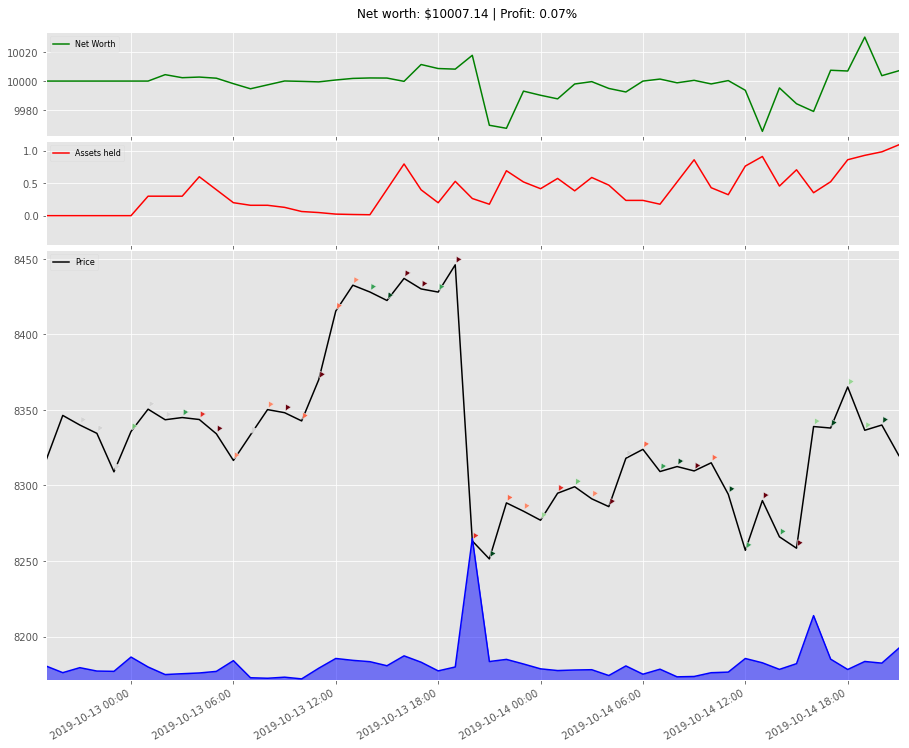

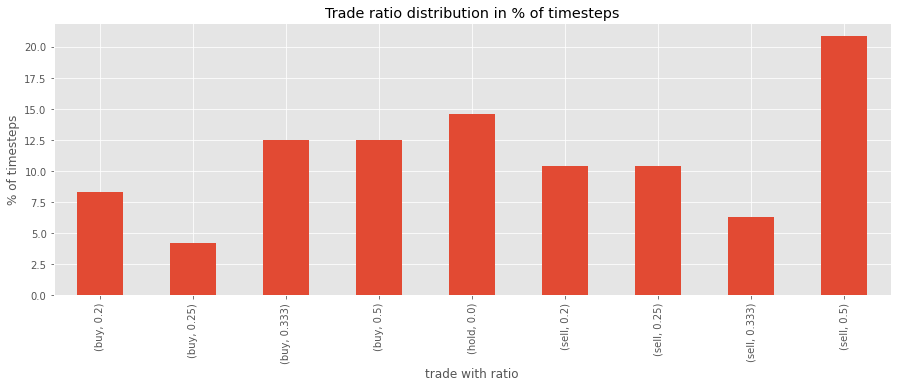

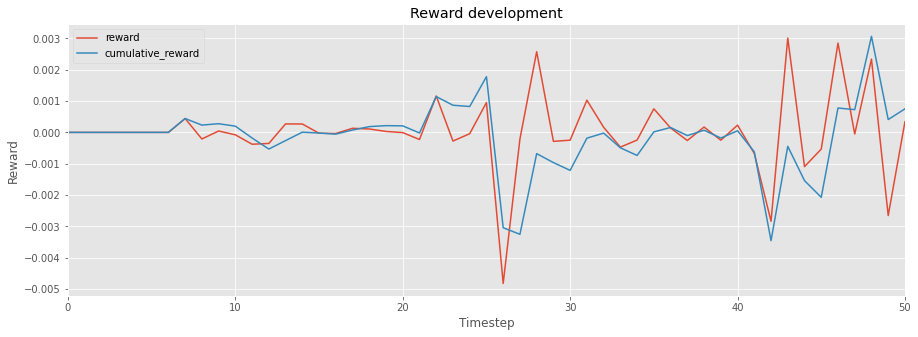

CPU times: user 3.7 s, sys: 199 ms, total: 3.9 s
Wall time: 3.91 s


In [23]:
%%time
run.predict(df=df, model=model, timesteps=50, train_test='test', rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 20050,
 'net_worths': [10000.0,
  10000.0,
  10018.25,
  10015.38,
  10013.39,
  10006.04,
  10018.63,
  10023.27,
  10019.52,
  10019.91,
  10019.26,
  10016.1,
  10011.38,
  10013.64,
  10014.76,
  10014.16,
  10012.56,
  10026.73,
  10058.07,
  10072.02,
  10069.27,
  10067.56,
  10078.51,
  10071.75,
  10069.63,
  10088.78,
  9886.7,
  9876.85,
  9899.92,
  9894.92,
  9888.64,
  9902.74,
  9906.12,
  9898.2,
  9895.64,
  9918.94,
  9922.17,
  9910.99,
  9913.99,
  9912.68,
  9917.1,
  9899.99,
  9862.58,
  9879.17,
  9870.11,
  9864.2,
  9895.84,
  9895.59,
  9900.92,
  9888.22,
  9890.41],
 'trades': [{'step': 20000,
   'amount': 0.6012506,
   'total': 5000.0,
   'type': 'buy',
   'action_amount': 0.5},
  {'step': 20001,
   'amount': 0.15031265,
   'total': 1254.56,
   'type': 'sell',
   'action_amount': 0.25},
  {'step': 20002,
   'amount': 0.09018759,
   'total': 752.16,
   'type': 'sell',
   'action_amount': 0.2},
  {'step': 20003,
   'amount': 0.07215007,
   '

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])

In [11]:
import pandas as pd
test = x['account_history']['asset_held']


In [14]:
test.index=test.index+20000

In [15]:
test

20000    0.000000
20001    0.601251
20002    0.450938
20003    0.360750
20004    0.288600
20005    0.471728
20006    0.314485
20007    0.535944
20008    0.267972
20009    0.501158
20010    0.334105
20011    0.267284
20012    0.133642
20013    0.066821
20014    0.293326
20015    0.293326
20016    0.520033
20017    0.689510
20018    0.815931
20019    0.611949
20020    0.305974
20021    0.750652
20022    0.972606
20023    1.017034
20024    1.061472
20025    1.105815
20026    0.829361
20027    0.622021
20028    0.908220
20029    1.051415
20030    0.788562
20031    0.788562
20032    0.991095
20033    0.495548
20034    0.728452
20035    0.546339
20036    0.761562
20037    0.905298
20038    0.452649
20039    0.822782
20040    0.822782
20041    1.008193
20042    0.504097
20043    0.378072
20044    0.786066
20045    0.393033
20046    0.262022
20047    0.196516
20048    0.443284
20049    0.628996
20050    0.907448
Name: asset_held, dtype: float64

In [46]:
net_worths.loc[slicer]

20000    10000.00
20001    10000.00
20002    10000.00
20003    10000.00
20004     9998.34
20005     9994.53
20006     9998.53
20007    10004.62
20008    10003.18
20009    10003.84
20010    10003.05
20011    10000.20
20012     9997.54
20013     9999.58
20014    10001.20
20015    10001.04
20016     9997.58
20017    10011.43
20018    10040.78
20019    10056.50
20020    10052.06
20021    10049.29
20022    10061.59
20023    10055.74
20024    10053.63
20025    10067.39
20026     9962.73
20027     9954.05
20028     9975.73
20029     9970.81
20030     9965.46
20031     9977.46
20032     9979.75
20033     9977.60
20034     9976.91
20035     9992.61
20036     9996.36
20037     9988.93
20038     9991.37
20039     9988.89
20040     9994.42
20041     9971.81
20042     9930.08
20043     9967.10
20044     9949.10
20045     9944.87
20046    10015.98
20047    10015.00
20048    10043.34
20049    10028.40
20050    10031.39
dtype: float64

In [38]:
int(start_step)

20000

In [50]:
import pandas as pd
start_index = 10
index_range=range(start_index, len(x['net_worths'])+start_index)
test = pd.Series(x['net_worths'], index=index_range)

In [51]:
test

10    10000.00
11    10000.00
12    10000.00
13    10000.00
14    10000.00
15    10000.00
16    10000.00
17    10000.00
18    10000.00
19    10000.00
20    10000.00
21    10000.00
22    10000.00
23     9984.73
24    10003.95
25    10016.35
26    10012.43
27    10013.72
28    10012.37
29    10004.50
30     9989.81
31    10006.99
32    10024.03
33    10021.76
34    10016.93
35    10045.38
36    10096.39
37    10111.73
38    10109.03
39    10105.68
40    10112.67
41    10107.68
42    10106.56
43    10120.24
44     9965.47
45     9957.93
46     9992.07
47     9989.54
48     9986.79
49    10001.70
50    10005.58
51     9997.14
52     9991.67
53    10008.57
54    10011.08
55    10007.97
56    10010.31
57    10007.54
58    10012.68
59     9991.07
60     9971.80
61     9994.56
62     9973.86
63     9969.00
64    10010.67
65    10010.17
66    10028.88
67    10013.10
68    10014.37
dtype: float64

# Traintest TODO:
- Render function TradingCHartStatic must support other start than 0. Most convenient ways I can think of:
    * to convert the lists containing data to Series with dynamic index (might need to use something else that Slice, dunno if that's compatible with pandas data types.
    * to pad the list in TradingChartStatic. This will require also to cut the padded values out in plotting, which I believe will be simpler in the first option.
- Make sure the overlap is 0
- Set the logic for calculating breking point date from config info
- Pad with data__n_timesteps also for test data to ensure no indirect overlap

In [11]:
test = df['Timestamp']

In [15]:
test.iloc[slice(10,15)]

10   2017-07-01 21:00:00
11   2017-07-01 22:00:00
12   2017-07-01 23:00:00
13   2017-07-02 00:00:00
14   2017-07-02 01:00:00
Name: Timestamp, dtype: datetime64[ns]